In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

# Read the real data

In [2]:
data_dir = pathlib.Path("..") / "data"
data = mg.load_qdm(data_dir / "Bz_uc0.mat")
data

<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 352.4 94.89 41.62 288.4 ... -4.196 -53.56 2.103
Attributes:
    file_name:  ..\data\Bz_uc0.mat

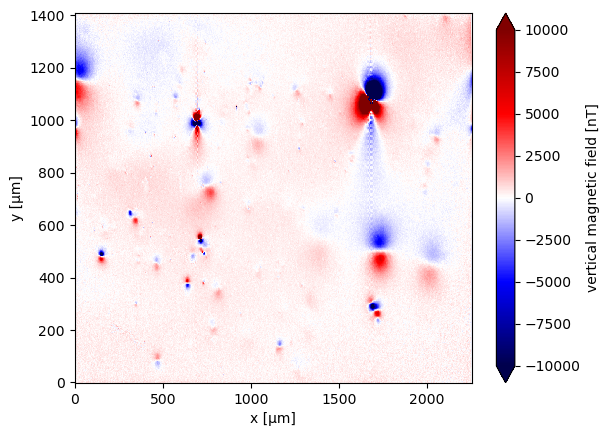

In [3]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

In [4]:
table = vd.grid_to_table(data)

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [5]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)

data_up.z.attrs = {"units": "µm"}

data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 206.0 199.8 194.2 199.0 ... 282.8 266.5 236.6 204.7

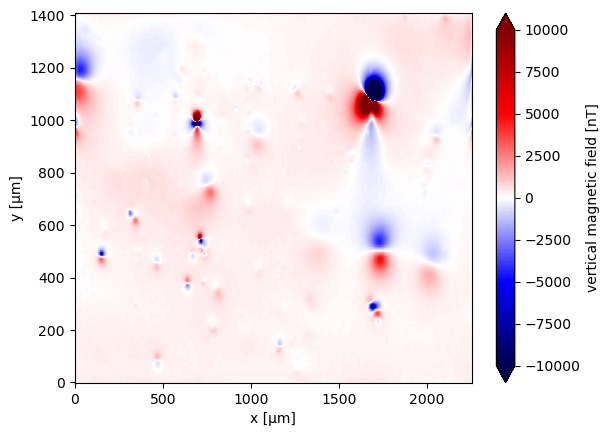

In [6]:
scale = 10000
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=scale, vmin=-scale)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [7]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 206.0 199.8 194.2 199.0 ... 282.8 266.5 236.6 204.7
    tga      (y, x) float64 6.937 8.888 8.154 6.013 ... 24.89 24.13 23.33 21.11
    x_deriv  (y, x) float64 -2.652 -2.519 -0.1715 3.022 ... -9.835 -13.17 -13.58
    y_deriv  (y, x) float64 6.135 8.487 7.263 4.485 ... -17.43 -11.83 -1.096
    z_deriv  (y, x) float64 1.858 0.7877 3.704 -2.628 ... 16.04 13.48 15.2 16.12

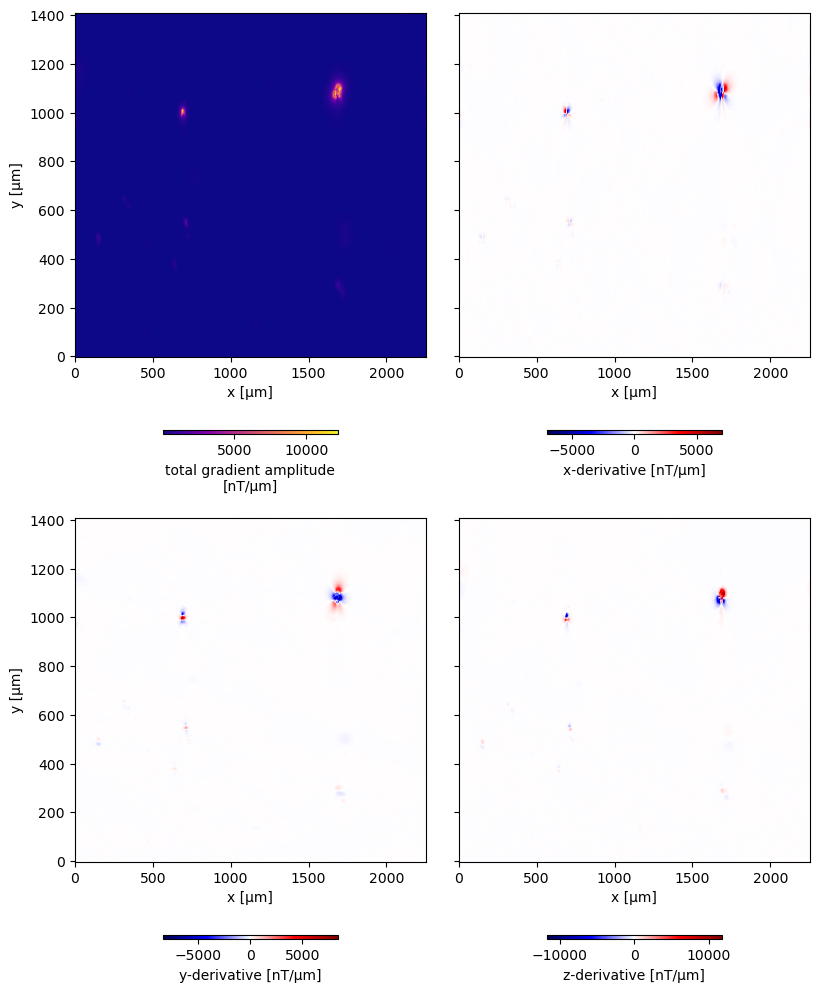

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
        vmax=None
        vmin=None
    else:
        vmax= None# 500
        vmin= None#-500
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [9]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

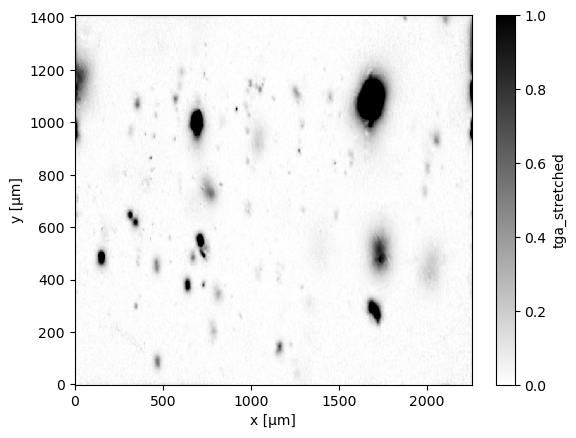

In [10]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [11]:
windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 200],
    size_increment=1.3,
    threshold=0.025,
    overlap=0.0,
    exclude_border=30,
    nsizes=10,
)
print('Sources detected: ', np.shape(windows)[0])

Sources detected:  100


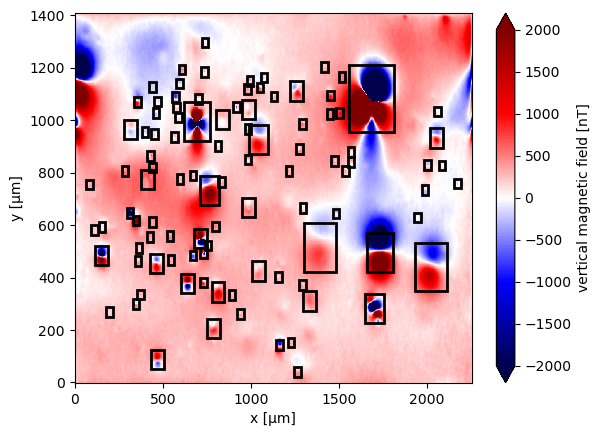

In [12]:
ax = plt.subplot(111)
scale = 2000
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", vmax=scale, vmin=-scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)  
ax.set_aspect("auto")

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion

Run the Euler Deconvolution and the inversion on each window.

In [13]:
positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
#     base_level = 0
    
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = position[2] > 0
    poor_fit = False
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)

print()
print("Dipole moments estimated:", positions.shape[1])

R²: 0.8878576913878151 and SNR: 9.518730490742428
R²: 0.9173513636991012 and SNR: 10.93777914137231
R²: 0.9946005039683813 and SNR: 23.05961209420554
R²: 0.7460754916587296 and SNR: 5.977254924742987
R²: 0.9728510000308315 and SNR: 15.665320041563835
R²: 0.9972637031581696 and SNR: 25.690723677424444
R²: 0.9816835127392134 and SNR: 17.519415551075294
R²: 0.9848937372877438 and SNR: 18.22805543942718
R²: 0.9991782555940184 and SNR: 31.411962581383985
R²: 0.7373843539031184 and SNR: 6.1955824281808125
R²: 0.9960756733896364 and SNR: 24.070483524940013
R²: 0.9603006258010953 and SNR: 14.128411903182176
R²: 0.9991423021526928 and SNR: 30.676100198446996
R²: 0.9970542831194271 and SNR: 25.869717814706306
R²: 0.9515262756130543 and SNR: 13.278426395217727
R²: 0.938429171309109 and SNR: 12.116199987881714
R²: 0.9949075769752458 and SNR: 23.081515310170055
R²: 0.9790322181547473 and SNR: 16.790183675715568
R²: 0.9679487807235324 and SNR: 15.023904818253781
R²: 0.966754444912002 and SNR: 14.918

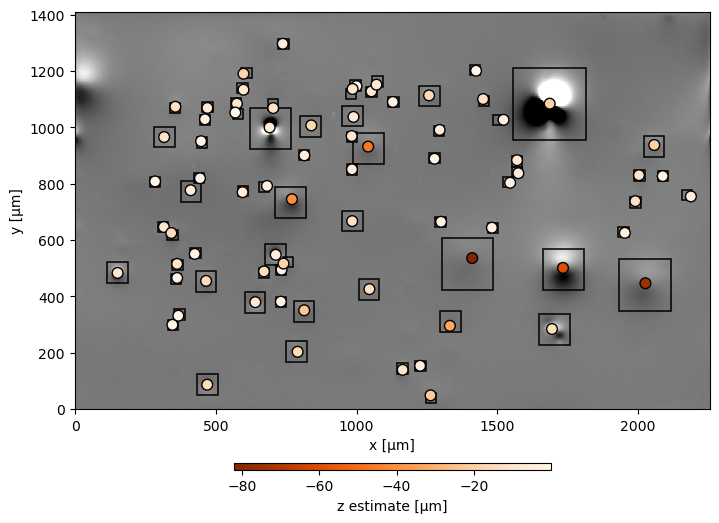

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)
scale = 5000
data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, add_colorbar=False)
for window in windows_filtered:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=positions[2], cmap="Oranges_r", s=60, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

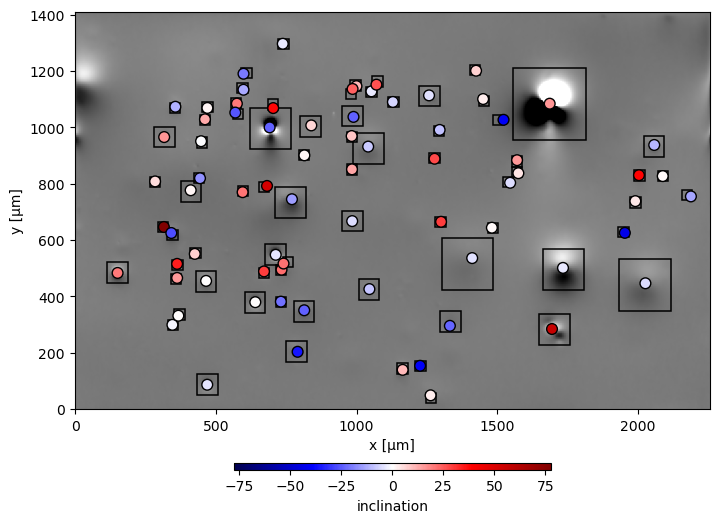

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)
scale = 5000
data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, add_colorbar=False)
for window in windows_filtered:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

estimated = mg.vector_to_angles(estimated_dipole_moments)
scale = vd.maxabs(estimated[0])
tmp = ax.scatter(*positions[:2], c=estimated[0], cmap="seismic", vmin=-scale, vmax=scale, s=60, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="inclination")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

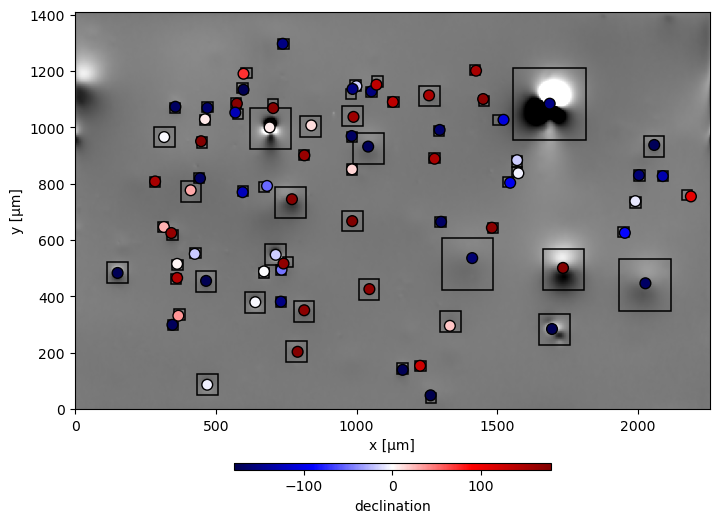

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)
scale = 5000
data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, add_colorbar=False)
for window in windows_filtered:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

estimated = mg.vector_to_angles(estimated_dipole_moments)
scale = vd.maxabs(estimated[1])
tmp = ax.scatter(*positions[:2], c=estimated[1], cmap="seismic", vmin=-scale, vmax=scale, s=60, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="declination")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

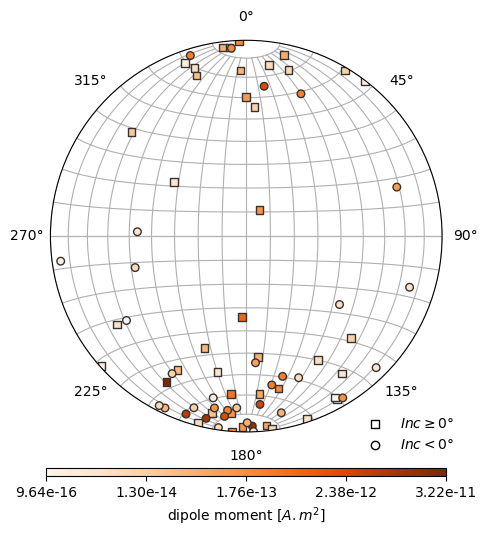

In [17]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

# Article figure

Make nice figures out of these results for the paper. These are more elaborate figures that are designed for the printed page in particular.

In [18]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

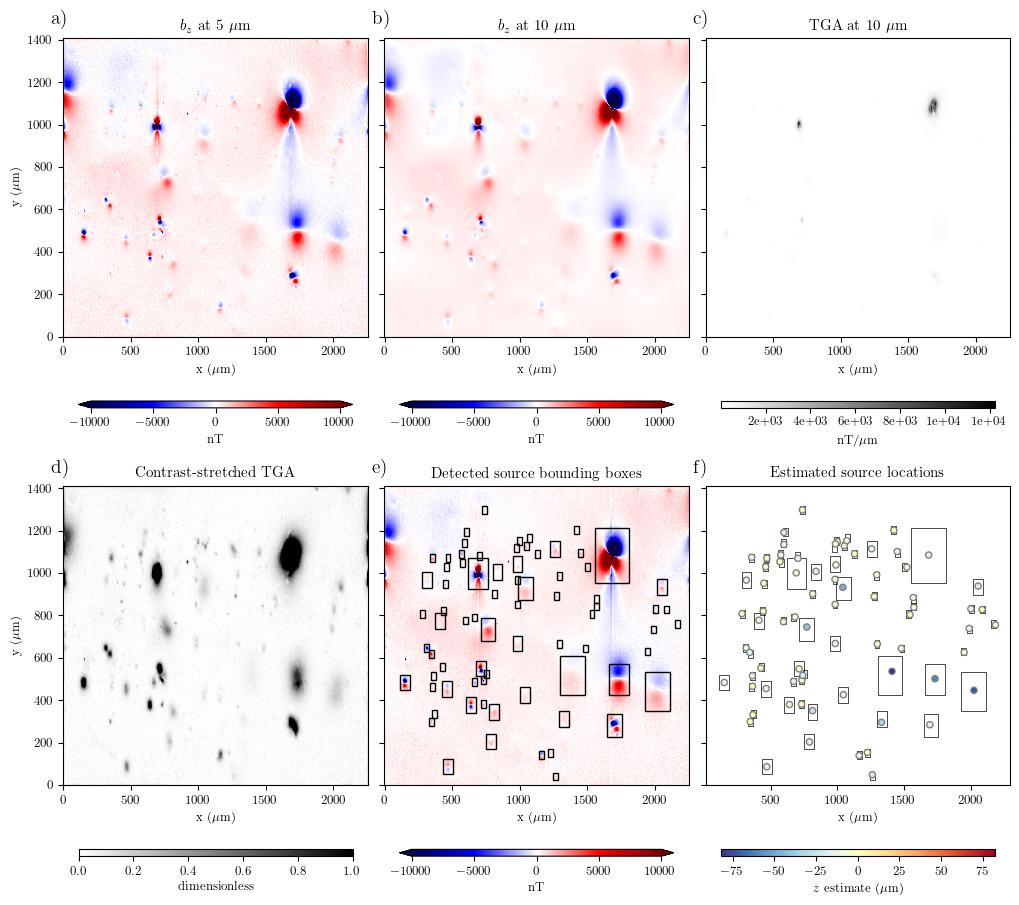

In [19]:
sensor_sample_distance = float(data.z.values.mean())
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 3, figsize=(10, 9), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    
    ax = axes[0]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    

    ax = axes[1]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("auto")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("auto")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("auto")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   
    
        
    ax = axes[5]  
    ax.set_aspect("auto")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=0.5,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(positions[2])
    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="RdYlBu_r", vmin=-scale, vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="$z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)
    
    fig.savefig(fig_dir / "real-data.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

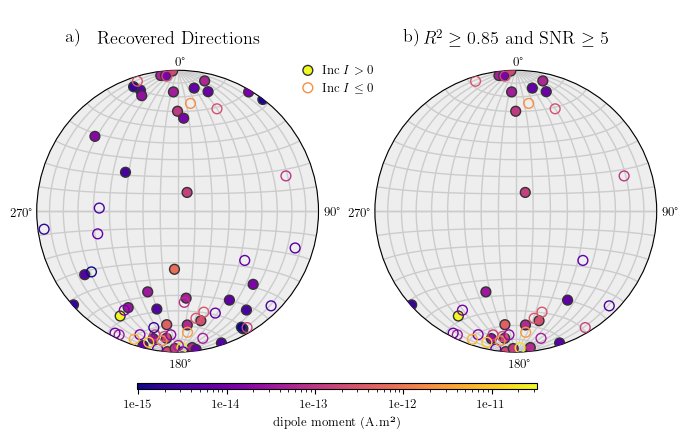

In [20]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 4))
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]

    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

    ax = fig.add_subplot(1, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T
    
    ax = fig.add_subplot(1, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs)

    titles = ('Recovered Directions', '$R^2 \geq 0.85$ and SNR $\geq 5$')

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
#         ax.set_azimuth_ticks([])
#         ax.grid(linestyle=':', color='gray')
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2)

    plt.show()


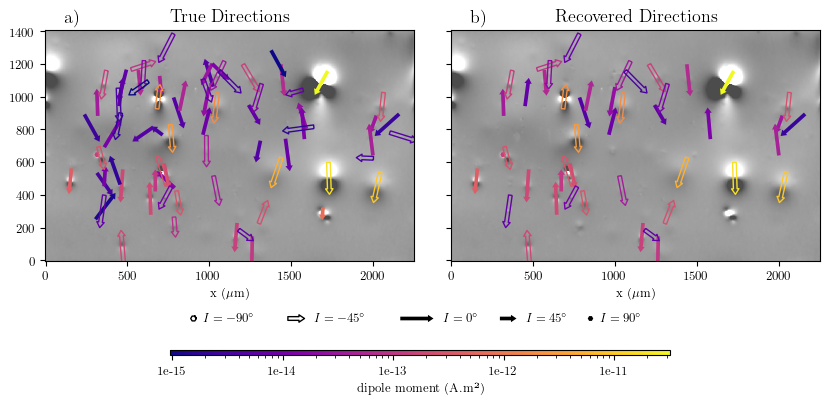

In [21]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(10, 5))
    
    axes = []
    
    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]

    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#     ax = fig.add_subplot(1, 3, 1)
#     axes.append(ax)
#     ax.set_title("Estimated dipole moments over the synthetic $b_z$")
#     scale = 2000
# #     ax.pcolormesh(data_up.bz, cmap="gray", vmin=-scale, vmax=scale)
#     data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
#                                    add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
    
#     tmp, posquiver, negquiver = mg.plot_dipole_moment(
#         dipole_coordinates, dipole_moments, 
#         ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
#         scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
#     )
#     ax.set_xlabel("x ($\mu$m)")
#     ax.set_ylabel("y ($\mu$m)")
#     ax.set_aspect("equal")
    
    
    ax = fig.add_subplot(1, 2, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 2000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
#     ax.pcolormesh(data_up.bz, cmap="gray", vmin=-scale, vmax=scale)
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_xlabel("x ($\mu$m)")
#     ax.set_ylabel("y ($\mu$m)")
    ax.set_aspect("equal")

    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver, 0.4, -0.25, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k')
    ax.quiverkey(negquiver, 0.7, -0.25, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k')
    ax.quiverkey(posquiver, 1.05, -0.25, 90, label="$I =   0^\circ$", labelpos="E", color='k')
    ax.quiverkey(posquiver, 1.275, -0.25, 45, label="$I =  45^\circ$", labelpos="E", color='k')
    ax.quiverkey(posquiver, 1.475, -0.25, 0., label="$I =  90^\circ$", labelpos="E", color='k')
    
    
    
    
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    
    ax = fig.add_subplot(1, 2, 2)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 2000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
#     ax.pcolormesh(data_up.bz, cmap="gray", vmin=-scale, vmax=scale)
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_xlabel("x ($\mu$m)")
#     ax.set_ylabel("y ($\mu$m)")
    ax.set_aspect("equal")
    plt.yticks(color='w')
    
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.075, 0.5, 0.01]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )
    

    titles = ('True Directions', 'Recovered Directions', '$R^2 \geq 0.85$ and SNR $\geq 5$')

    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_title(title, fontsize=13)
    fig.subplots_adjust(wspace=0.1)
    
    plt.show()


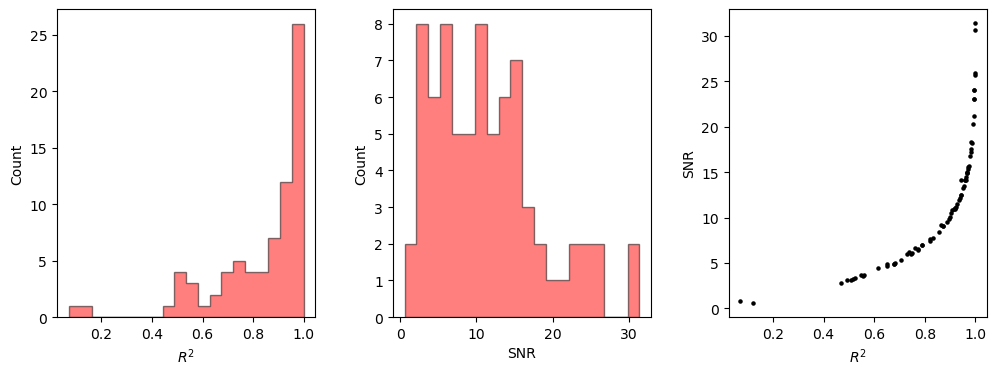

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.hist(calculated_r2, bins=20, histtype="stepfilled", color='r', edgecolor='k', alpha=0.5)
ax2.hist(calculated_SNR, bins=20, histtype="stepfilled", color='r', edgecolor='k', alpha=0.5)

ax1.set_xlabel('$R^2$')
ax1.set_ylabel('Count')
ax2.set_xlabel('SNR')
ax2.set_ylabel('Count')

ax3.scatter(calculated_r2, calculated_SNR, s=5, color='k')
ax3.set_ylabel('SNR')
ax3.set_xlabel('$R^2$')

plt.subplots_adjust(wspace=0.3)

plt.show()

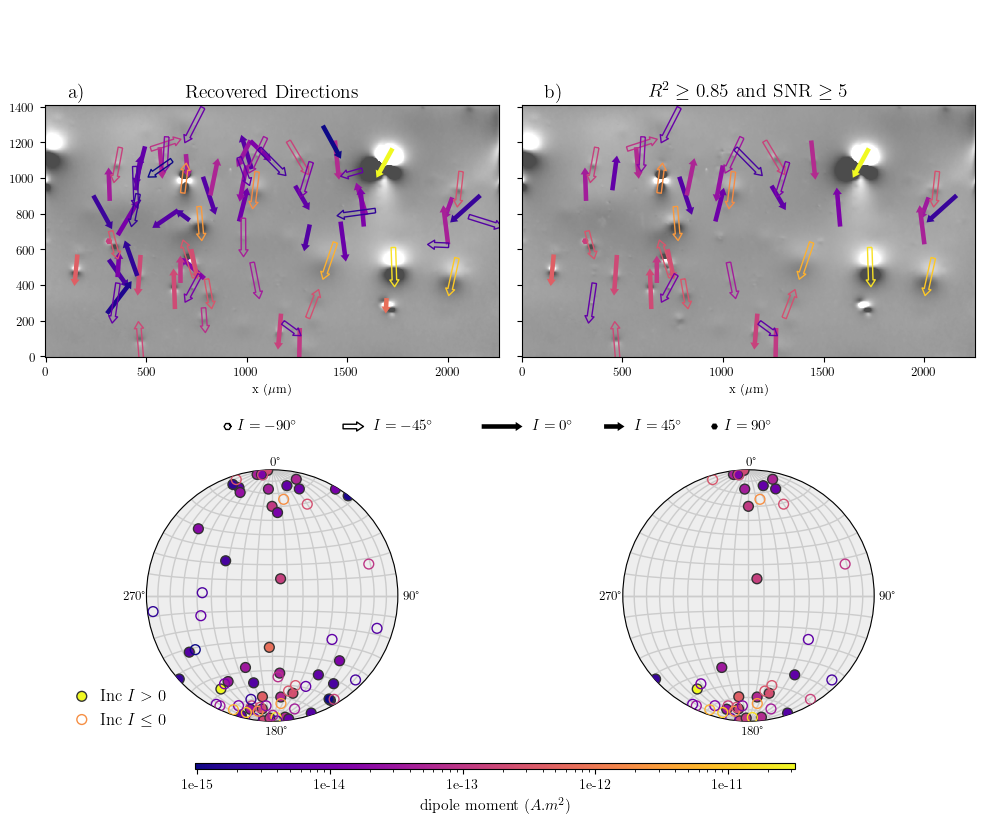

In [23]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(12, 8))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################

    ax = fig.add_subplot(2, 2, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 2000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_xlabel("x ($\mu$m)")

    
    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,0.4, -0.275, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, 0.7, -0.275, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 1.05, -0.275, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 1.275, -0.275, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 1.475, -0.275, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    
    ax = fig.add_subplot(2, 2, 2)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 2000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_xlabel("x ($\mu$m)")
    plt.yticks(color='w', alpha=0.0)
    
    clb = fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
    
#################################################################################################
#                                           Stereograms
#################################################################################################

    ax = fig.add_subplot(2, 2, 3, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})

    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T
    
    ax = fig.add_subplot(2, 2, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    
    titles = ('Recovered Directions', '$R^2 \geq 0.85$ and SNR $\geq 5$')

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.05, hspace=0.45)
    fig.savefig(fig_dir / "real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

### Show the observed and predicted data

In [24]:
x_, y_ = np.meshgrid(data.x.values, data.y.values)
predicted_coordinates = ([x_, y_ , data_up.z.values])
predicted_data = mg.dipole_bz(predicted_coordinates, positions, estimated_dipole_moments)

In [25]:
data_up = data_up.assign(predicted_data=(['y','x'],predicted_data))
data_up.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data_up.bz.values - data_up.predicted_data.values

data_up = data_up.assign(error=(['y','x'],error))
data_up.error.attrs = {"long_name": "residual-data", "units": "nT"}

data_up

<xarray.Dataset>
Dimensions:         (y: 600, x: 960)
Coordinates:
  * y               (y) float64 0.0 2.35 4.7 ... 1.403e+03 1.405e+03 1.408e+03
  * x               (x) float64 0.0 2.35 4.7 ... 2.249e+03 2.251e+03 2.254e+03
    z               (y, x) float64 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz              (y, x) float64 206.0 199.8 194.2 199.0 ... 266.5 236.6 204.7
    tga             (y, x) float64 6.937 8.888 8.154 6.013 ... 24.13 23.33 21.11
    x_deriv         (y, x) float64 -2.652 -2.519 -0.1715 ... -13.17 -13.58
    y_deriv         (y, x) float64 6.135 8.487 7.263 ... -17.43 -11.83 -1.096
    z_deriv         (y, x) float64 1.858 0.7877 3.704 ... 13.48 15.2 16.12
    tga_stretched   (y, x) float64 0.02272 0.03036 0.02749 ... 0.08693 0.07822
    predicted_data  (y, x) float64 0.1771 0.1778 0.1785 ... 1.06 1.051 1.042
    error           (y, x) float64 205.8 199.6 194.0 198.8 ... 265.5 235.5 203.6

In [26]:
data_up

<xarray.Dataset>
Dimensions:         (y: 600, x: 960)
Coordinates:
  * y               (y) float64 0.0 2.35 4.7 ... 1.403e+03 1.405e+03 1.408e+03
  * x               (x) float64 0.0 2.35 4.7 ... 2.249e+03 2.251e+03 2.254e+03
    z               (y, x) float64 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz              (y, x) float64 206.0 199.8 194.2 199.0 ... 266.5 236.6 204.7
    tga             (y, x) float64 6.937 8.888 8.154 6.013 ... 24.13 23.33 21.11
    x_deriv         (y, x) float64 -2.652 -2.519 -0.1715 ... -13.17 -13.58
    y_deriv         (y, x) float64 6.135 8.487 7.263 ... -17.43 -11.83 -1.096
    z_deriv         (y, x) float64 1.858 0.7877 3.704 ... 13.48 15.2 16.12
    tga_stretched   (y, x) float64 0.02272 0.03036 0.02749 ... 0.08693 0.07822
    predicted_data  (y, x) float64 0.1771 0.1778 0.1785 ... 1.06 1.051 1.042
    error           (y, x) float64 205.8 199.6 194.0 198.8 ... 265.5 235.5 203.6

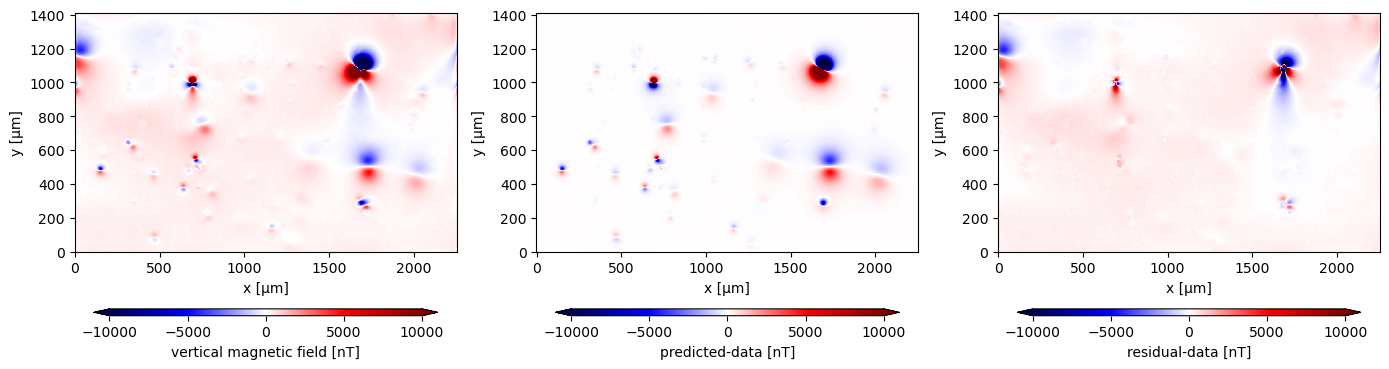

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +10000
    vmin = -10000
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

### Show each window results
We displayed only the first 5 windows

All modeled sources: R2 = 0.8879120305852335 and SNR = 9.518411344740915
Individual source:   R2 = 0.8878576913878151 and SNR = 9.518730490742428


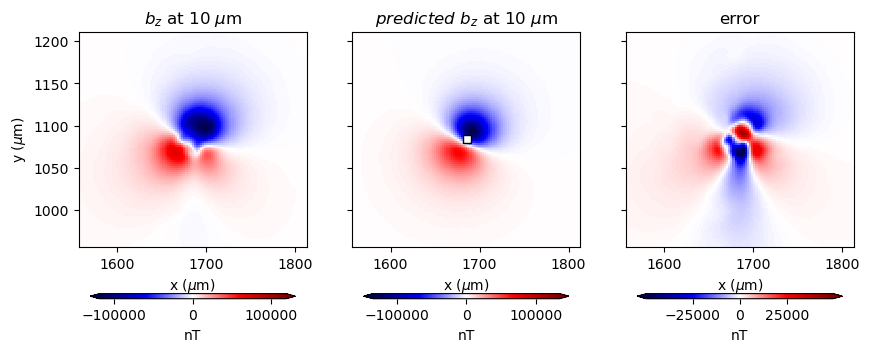

All modeled sources: R2 = 0.9069215996206151 and SNR = 10.929593647308666
Individual source:   R2 = 0.9173513636991012 and SNR = 10.93777914137231


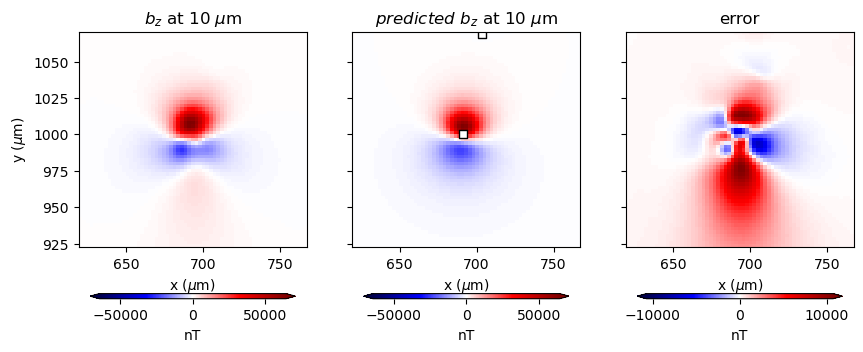

All modeled sources: R2 = 0.9787625939121739 and SNR = 23.05954602770933
Individual source:   R2 = 0.9946005039683813 and SNR = 23.05961209420554


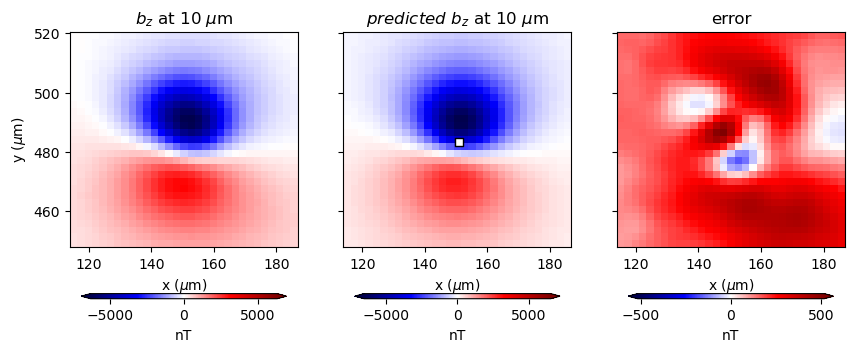

All modeled sources: R2 = 0.7421851546882703 and SNR = 5.987777238890425
Individual source:   R2 = 0.7460754916587296 and SNR = 5.977254924742987


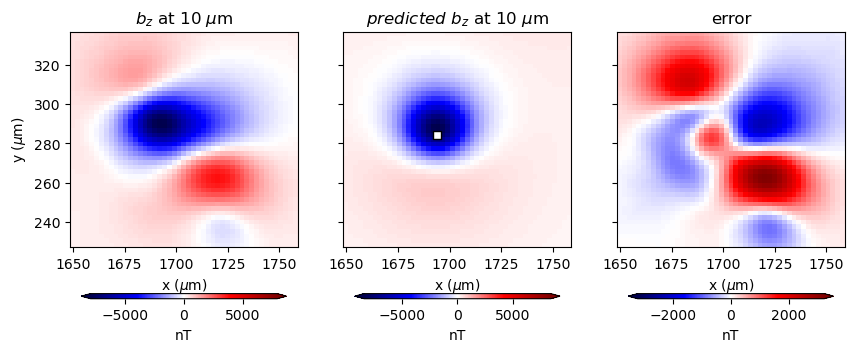

All modeled sources: R2 = 0.8937049830832579 and SNR = 17.407735940326184
Individual source:   R2 = 0.9728510000308315 and SNR = 15.665320041563835


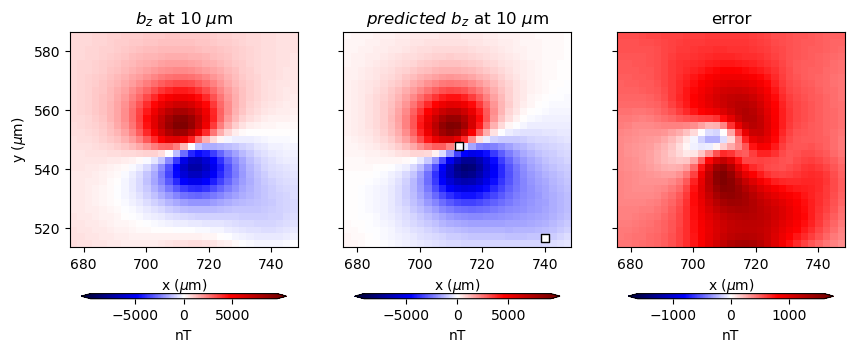

In [28]:
for window, r2, SNR in zip(windows_filtered[0:5], calculated_r2[0:5], calculated_SNR[0:5]):
    local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    
    ax = axes[0]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')

    
    ax = axes[1]
    ax.set_aspect("auto")
    ax.set_title(f"$predicted~b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    ax.scatter(positions[0], positions[1], color='w', marker='s', edgecolors='k')
    
    ax = axes[2]   
    ax.set_aspect("auto")
    ax.set_title("error")
    ax.set_xlabel("x ($\mu$m)")
    
    tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    residuals_sum_sq = np.sum((local_data.error.values)**2)
    r2_window = 1 - residuals_sum_sq / np.linalg.norm( np.array(local_data.bz.values) - float(local_data.bz.mean()) ) ** 2
    
    SNR_window = 10 * np.log10(np.var(local_data.bz.values, ddof=1) / np.var(local_data.error.values, ddof=1))
    
    # Compare R2 and SNR calculated with isolated windows and after calculating all sources contribution
    print(r"All modeled sources: R2 = %s and SNR = %s"%(r2_window, SNR_window))
    print(r"Individual source:   R2 = %s and SNR = %s"%(r2, SNR))
    

    plt.show()